# Model

In [29]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

X_train = pd.read_csv("../data/processed/X_train.csv")
X_val = pd.read_csv("../data/processed/X_val.csv")
X_test = pd.read_csv("../data/processed/X_test.csv")
y_train = pd.read_csv("../data/processed/y_train.csv")
y_val = pd.read_csv("../data/processed/y_val.csv")
y_test = pd.read_csv("../data/processed/y_test.csv")

target_variable = "tree_type"

## Baseline performance report

💡 Concept: Before exploring sophisticated algorithms, establish baseline performance that any complex model must beat. Strong baselines prevent false excitement about mediocre results and provide clear improvement targets.

In [24]:
def establish_baselines(X_train, y_train, cv_folds=5):
    """Establish comprehensive classification baselines"""
    baselines = {}

    # Level 1: Dummy baselines
    dummy_strategies = ["most_frequent", "stratified", "uniform"]
    for strategy in dummy_strategies:
        dummy = DummyClassifier(strategy=strategy, random_state=42)
        scores = cross_val_score(
            dummy, X_train, y_train, cv=cv_folds, scoring="accuracy"
        )
        baselines[f"Dummy_{strategy}"] = {
            "mean_accuracy": scores.mean(),
            "std_accuracy": scores.std(),
        }

    # Level 2: Simple models
    simple_models = {
        "Logistic_Regression": LogisticRegression(random_state=42, max_iter=1000),
        "Decision_Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
    }

    for name, model in simple_models.items():
        scores = cross_val_score(
            model, X_train, y_train, cv=cv_folds, scoring="accuracy"
        )
        baselines[name] = {"mean_accuracy": scores.mean(), "std_accuracy": scores.std()}

    return baselines


# Generate baseline report
def report_baselines(baselines):
    baseline_df = pd.DataFrame(baselines).T
    baseline_df = baseline_df.sort_values("mean_accuracy", ascending=False)

    print("BASELINE PERFORMANCE REPORT")
    print("=" * 40)
    for name, row in baseline_df.iterrows():
        print(f"{name:20s}: {row['mean_accuracy']:.3f} ± {row['std_accuracy']:.3f}")

    return baseline_df


baselines = establish_baselines(X_train, y_train[target_variable])
baseline_report = report_baselines(baselines)

BASELINE PERFORMANCE REPORT
Decision_Tree       : 0.846 ± 0.010
Logistic_Regression : 0.829 ± 0.012
Dummy_most_frequent : 0.546 ± 0.000
Dummy_stratified    : 0.508 ± 0.013
Dummy_uniform       : 0.498 ± 0.008


## Logistic Regression: The Linear Classifier Foundation

💡 Concept: Logistic regression is the fundamental linear classifier that transforms the linear regression approach to handle categorical outcomes as we discussed in earlier lessons. Despite its name, it's used for classification, not regression, and serves as the most interpretable baseline for binary and multiclass problems.

In [25]:
def demonstrate_logistic_regression(X_train, y_train, X_val, y_val):
    """Demonstrate logistic regression with interpretation"""
    
    # Train logistic regression
    log_reg = LogisticRegression(random_state=42, max_iter=1000)
    log_reg.fit(X_train, y_train)
    
    # Get predictions and probabilities
    y_pred = log_reg.predict(X_val)
    y_proba = log_reg.predict_proba(X_val)
    
    # Show feature importance (coefficients)
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'coefficient': log_reg.coef_[0],
        'abs_coefficient': np.abs(log_reg.coef_[0])
    }).sort_values('abs_coefficient', ascending=False)
    
    print("Feature Importance (Coefficients):")
    print(feature_importance.head())
    
    return log_reg, y_pred, y_proba

log_reg_model, y_val_pred, y_val_proba = demonstrate_logistic_regression(X_train, y_train[target_variable], X_val, y_val[target_variable])

Feature Importance (Coefficients):
          feature  coefficient  abs_coefficient
4      basal_area    -3.511734         3.511734
1  average_height     2.283268         2.283268
0             age    -1.005779         1.005779
3    trees_per_ha    -0.806444         0.806444
2             dbh    -0.130835         0.130835


## Decision Trees: Rule-Based Classification

💡 Concept: Decision trees classify by applying a series of if–then rules, splitting the data based on feature values. They are highly interpretable, handle mixed data types naturally, and form the base for powerful ensemble models like Random Forests and Gradient Boosting.

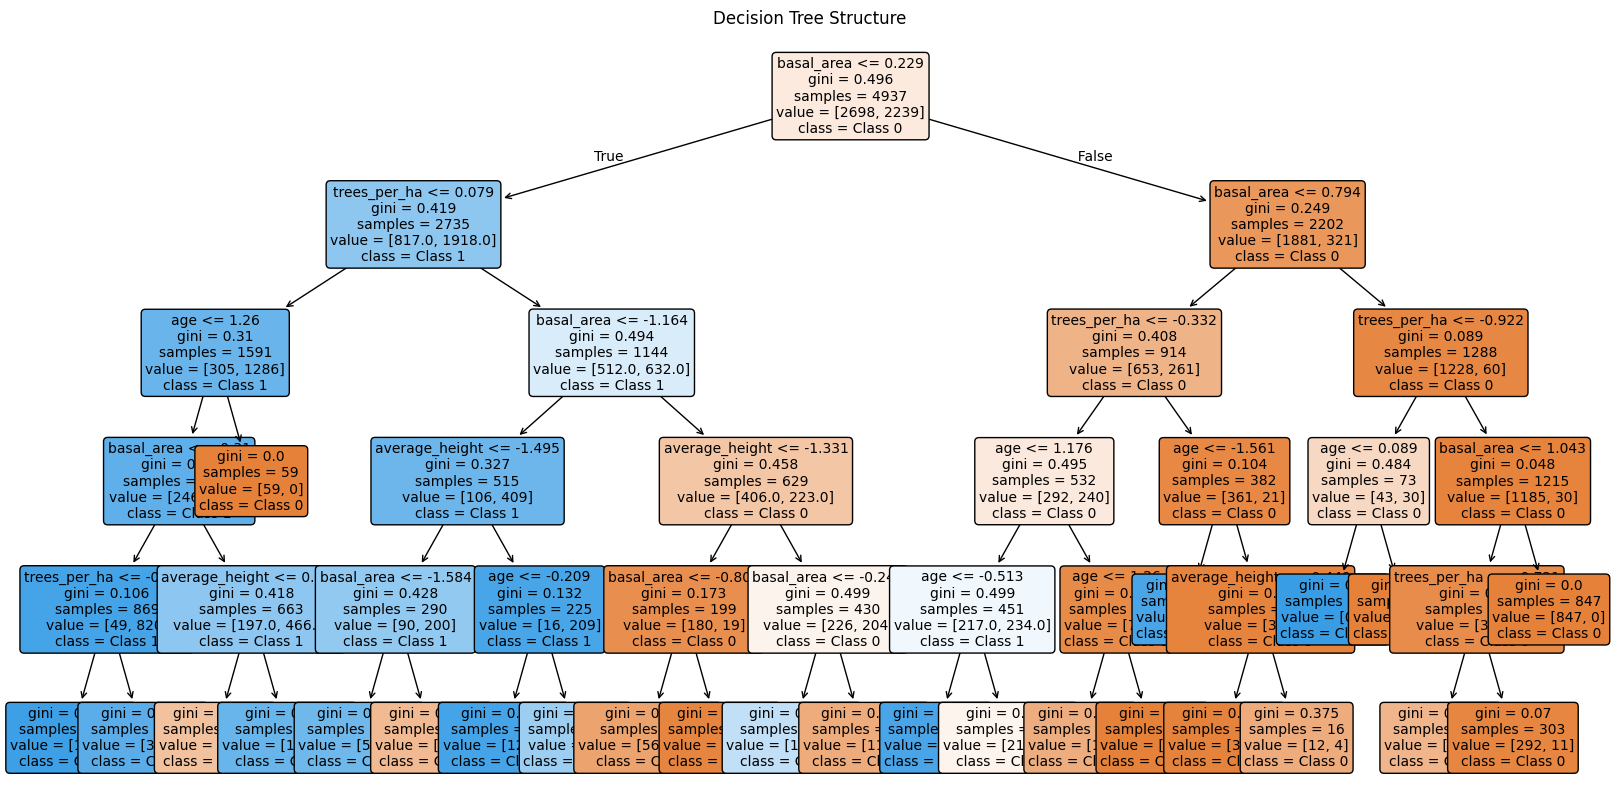

Decision Tree Rules:
|--- basal_area <= 0.23
|   |--- trees_per_ha <= 0.08
|   |   |--- age <= 1.26
|   |   |   |--- basal_area <= -0.31
|   |   |   |   |--- trees_per_ha <= -0.28
|   |   |   |   |   |--- class: deciduous
|   |   |   |   |--- trees_per_ha >  -0.28
|   |   |   |   |   |--- class: deciduous
|   |   |   |--- basal_area >  -0.31
|   |   |   |   |--- average_height <= 0.08
|   |   |   |   |   |--- class: coniferous
|   |   |   |   |--- average_height >  0.08
|   |   |   |   |   |--- class: deciduous
|   |   |--- age >  1.26
|   |   |   |--- class: coniferous
|   |--- trees_per_ha >  0.08
|   |   |--- basal_area <= -1.16
|   |   |   |--- average_height <= -1.50
|   |   |   |   |--- basal_area <= -1.58
|   |   |   |   |   |--- class: deciduous
|   |   |   |   |--- basal_area >  -1.58
|   |   |   |   |   |--- class: coniferous
|   |   |   |--- average_height >  -1.50
|   |   |   |   |--- age <= -0.21
|   |   |   |   |   |--- class: deciduous
|   |   |   |   |--- age >  -0.21
|

In [26]:
def demonstrate_decision_tree(X_train, y_train, X_val, y_val):
    """Demonstrate decision tree with visualization and interpretation"""
    
    # Train decision tree with controlled depth
    tree = DecisionTreeClassifier(
        max_depth=5,           # Prevent overfitting
        min_samples_split=20,  # Minimum samples to split
        min_samples_leaf=10,   # Minimum samples in leaf
        random_state=42
    )
    
    tree.fit(X_train, y_train)
    
    # Visualize the tree structure
    plt.figure(figsize=(20, 10))
    plot_tree(tree, 
              feature_names=X_train.columns,
              class_names=['Class 0', 'Class 1'],
              filled=True,
              rounded=True,
              fontsize=10)
    plt.title("Decision Tree Structure")
    plt.show()

    # Get text representation of rules
    tree_rules = export_text(tree, feature_names=list(X_train.columns))
    print("Decision Tree Rules:")
    print(tree_rules[:1000] + "..." if len(tree_rules) > 1000 else tree_rules)

    # Feature importance
    importance_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': tree.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nFeature Importance:")
    print(importance_df)
    
    return tree

decision_tree_model = demonstrate_decision_tree(X_train, y_train[target_variable], X_val, y_val[target_variable])

## Random Forest: Ensemble of Trees

💡 Concept: Random Forest builds many decision trees, each trained on a different subset of data and features. By averaging their predictions, it reduces overfitting while maintaining useful interpretability via feature importance scores.


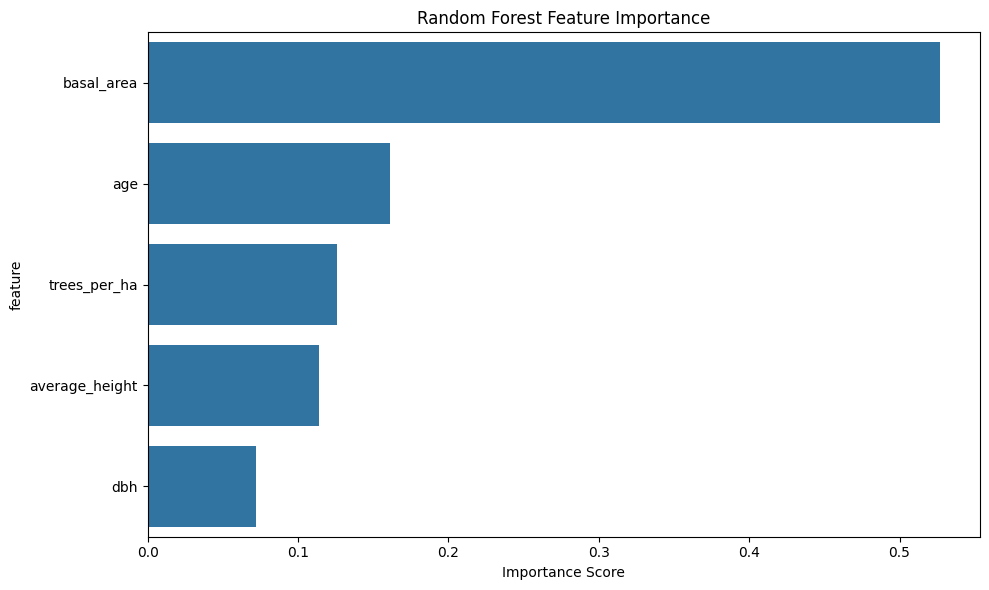

Number of trees: 100
Average tree depth: 10.0
Feature importance (top 5):
          feature  importance
4      basal_area    0.527155
0             age    0.161017
3    trees_per_ha    0.126128
1  average_height    0.113742
2             dbh    0.071957
Out-of-bag score: 0.901
This estimates generalization without validation set!


In [27]:
def demonstrate_random_forest(X_train, y_train, X_val, y_val):
    """Demonstrate Random Forest with feature importance analysis"""
    
    # Train Random Forest
    rf = RandomForestClassifier(
        n_estimators=100,      # Number of trees
        max_depth=10,          # Maximum depth per tree
        min_samples_split=20,  # Minimum samples to split
        min_samples_leaf=5,    # Minimum samples per leaf
        max_features='sqrt',   # Features per split
        bootstrap=True,        # Use bootstrap sampling
        random_state=42,
        n_jobs=-1              # Use all processors
    )
    
    rf.fit(X_train, y_train)
    
    # Feature importance analysis
    importance_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf.feature_importances_,
    }).sort_values('importance', ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    top_features = importance_df.head(10)
    sns.barplot(data=top_features, x='importance', y='feature')
    plt.title('Random Forest Feature Importance')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()
    
    # Individual tree analysis
    print(f"Number of trees: {rf.n_estimators}")
    print(f"Average tree depth: {np.mean([tree.get_depth() for tree in rf.estimators_]):.1f}")
    print(f"Feature importance (top 5):")
    print(importance_df.head())
    
    return rf, importance_df

# Out-of-bag score evaluation
def analyze_rf_performance(rf, X_train, y_train):
    """Analyze Random Forest performance including OOB score"""
    
    # Create RF with OOB scoring enabled
    rf_oob = RandomForestClassifier(
        n_estimators=100,
        oob_score=True,  # Enable out-of-bag scoring
        random_state=42,
        n_jobs=-1
    )
    
    rf_oob.fit(X_train, y_train)
    
    print(f"Out-of-bag score: {rf_oob.oob_score_:.3f}")
    print("This estimates generalization without validation set!")
    
    return rf_oob

rf_model, rf_importance = demonstrate_random_forest(X_train, y_train[target_variable], X_val, y_val[target_variable])
rf_oob_model = analyze_rf_performance(rf_model, X_train, y_train[target_variable])

## Support Vector Machines: Maximum Margin Classification

💡 Concept: Support Vector Machines (SVM) find the optimal decision boundary by maximizing the margin between classes. They work well for both linear and non-linear classification through the kernel trick, making them powerful for complex pattern recognition.

In [28]:
def demonstrate_svm(X_train, y_train, X_val, y_val):
    """Demonstrate SVM with different kernels"""
    
    # SVM requires feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    # Try different SVM kernels
    kernels = ['linear', 'rbf', 'poly']
    svm_results = {}
    
    for kernel in kernels:
        print(f"\n--- SVM with {kernel} kernel ---")
        
        svm = SVC(
            kernel=kernel,
            C=1.0,                 # Regularization parameter
            gamma='scale',         # Kernel coefficient (for rbf, poly)
            probability=True,      # Enable probability estimates
            random_state=42
        )
        
        svm.fit(X_train_scaled, y_train)
        
        # Performance metrics
        train_score = svm.score(X_train_scaled, y_train)
        val_score = svm.score(X_val_scaled, y_val)
        
        print(f"Training accuracy: {train_score:.3f}")
        print(f"Validation accuracy: {val_score:.3f}")
        print(f"Number of support vectors: {svm.n_support_}")
        print(f"Support vector ratio: {sum(svm.n_support_) / len(X_train):.3f}")
        
        svm_results[kernel] = {
            'model': svm,
            'train_score': train_score,
            'val_score': val_score,
            'n_support': sum(svm.n_support_)
        }
    
    return svm_results, scaler

# Hyperparameter tuning for SVM
def tune_svm_hyperparameters(X_train, y_train):
    """Demonstrate SVM hyperparameter tuning"""
    
    # Define parameter grid
    param_grid = {
        'C': [0.1, 1, 10, 100],              # Regularization
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],  # Kernel coefficient
        'kernel': ['rbf', 'poly', 'linear']
    }
    
    svm = SVC(probability=True, random_state=42)

    # Grid search with cross-validation
    grid_search = GridSearchCV(
        svm, param_grid, 
        cv=5, 
        scoring='accuracy',
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.3f}")
    
    return grid_search.best_estimator_

svm_results, svm_scaler = demonstrate_svm(X_train, y_train[target_variable], X_val, y_val[target_variable])
best_svm_model = tune_svm_hyperparameters(X_train, y_train[target_variable])


--- SVM with linear kernel ---
Training accuracy: 0.830
Validation accuracy: 0.815
Number of support vectors: [887 890]
Support vector ratio: 0.360

--- SVM with rbf kernel ---
Training accuracy: 0.873
Validation accuracy: 0.860
Number of support vectors: [834 831]
Support vector ratio: 0.337

--- SVM with poly kernel ---
Training accuracy: 0.850
Validation accuracy: 0.848
Number of support vectors: [1175 1183]
Support vector ratio: 0.478


KeyboardInterrupt: 

## k-Nearest Neighbors: Instance-Based Learning

💡 Concept: k-Nearest Neighbors (k-NN) classifies a new observation by looking at the k closest points in the training set and using majority vote.
It’s a lazy learner. There’s no explicit model training, and it adapts to local patterns without assuming a specific data distribution.

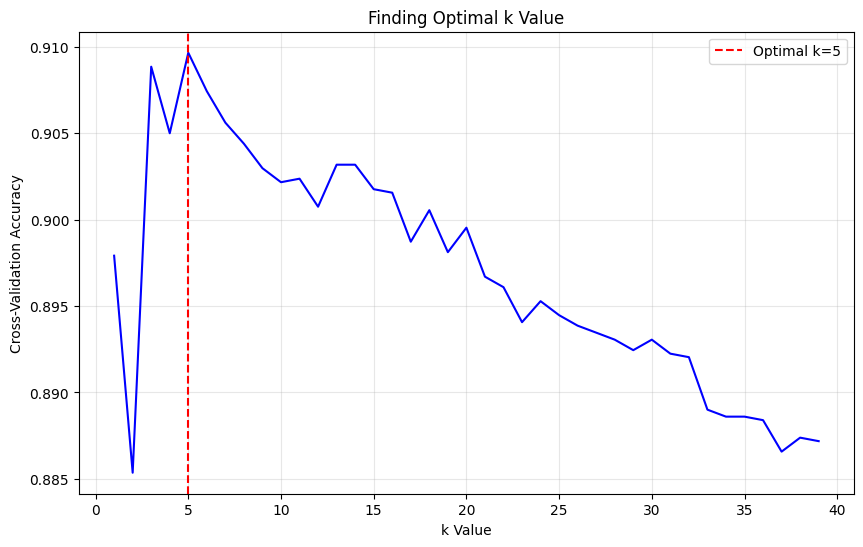

Optimal k: 5
Best CV score: 0.910


5

In [ ]:
def find_optimal_k(X_train, y_train, max_k=50):
    """Find optimal k using cross-validation"""
        
    k_range = range(1, min(max_k, len(X_train)//5))  # Don't exceed 20% of data
    cv_scores = []
    
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
        cv_scores.append(scores.mean())
    
    optimal_k = k_range[np.argmax(cv_scores)]
    
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, cv_scores, 'b-')
    plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal k={optimal_k}')
    plt.xlabel('k Value')
    plt.ylabel('Cross-Validation Accuracy')
    plt.title('Finding Optimal k Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"Optimal k: {optimal_k}")
    print(f"Best CV score: {max(cv_scores):.3f}")
    
    return optimal_k

find_optimal_k(X_train, y_train[target_variable], max_k=40)

## Naive Bayes: Probabilistic Classification

💡 Concept: Naive Bayes applies Bayes' theorem with the "naive" assumption that features are independent given the class as we discussed in earlier lessons. Despite this strong assumption, it works surprisingly well for many real-world problems, especially text classification.

In [31]:


def demonstrate_naive_bayes(X_train, y_train, X_val, y_val):
    """Demonstrate different types of Naive Bayes classifiers"""
    
    # Different Naive Bayes variants
    nb_models = {
        'Gaussian': GaussianNB(),           # For continuous features
        'Multinomial': MultinomialNB(),     # For count/frequency features
        'Bernoulli': BernoulliNB()          # For binary features
    }
    
    results = {}
    
    for name, model in nb_models.items():
        try:
            # Some variants require non-negative features
            if name == 'Multinomial':
                X_train_pos = np.where(X_train < 0, 0, X_train)
                X_val_pos = np.where(X_val < 0, 0, X_val)
            else:
                X_train_pos = X_train
                X_val_pos = X_val
            
            model.fit(X_train_pos, y_train)
            
            train_score = model.score(X_train_pos, y_train)
            val_score = model.score(X_val_pos, y_val)

            # Get class probabilities
            y_proba = model.predict_proba(X_val_pos)
            
            results[name] = {
                'model': model,
                'train_score': train_score,
                'val_score': val_score,
                'probabilities': y_proba
            }
            
            print(f"{name} Naive Bayes:")
            print(f"  Training accuracy: {train_score:.3f}")
            print(f"  Validation accuracy: {val_score:.3f}")

            # Show class priors
            if hasattr(model, 'class_prior_'):
                print(f"  Class priors: {model.class_prior_}")
            
        except Exception as e:
            print(f"{name} Naive Bayes failed: {e}")
    
    return results

demonstrate_naive_bayes(X_train, y_train[target_variable], X_val, y_val[target_variable])

Gaussian Naive Bayes:
  Training accuracy: 0.712
  Validation accuracy: 0.713
  Class priors: [0.54648572 0.45351428]
Multinomial Naive Bayes:
  Training accuracy: 0.618
  Validation accuracy: 0.612
Bernoulli Naive Bayes:
  Training accuracy: 0.770
  Validation accuracy: 0.770


{'Gaussian': {'model': GaussianNB(),
  'train_score': 0.711970832489366,
  'val_score': 0.7132442284325637,
  'probabilities': array([[0.96832786, 0.03167214],
         [0.95688417, 0.04311583],
         [0.24894171, 0.75105829],
         ...,
         [0.87447489, 0.12552511],
         [0.19254483, 0.80745517],
         [0.98097766, 0.01902234]])},
 'Multinomial': {'model': MultinomialNB(),
  'train_score': 0.618391735871987,
  'val_score': 0.6123936816524909,
  'probabilities': array([[0.83091082, 0.16908918],
         [0.68203521, 0.31796479],
         [0.52857655, 0.47142345],
         ...,
         [0.72938421, 0.27061579],
         [0.49240991, 0.50759009],
         [0.82278511, 0.17721489]])},
 'Bernoulli': {'model': BernoulliNB(),
  'train_score': 0.7699007494429816,
  'val_score': 0.7703523693803159,
  'probabilities': array([[0.90698367, 0.09301633],
         [0.90698367, 0.09301633],
         [0.29678525, 0.70321475],
         ...,
         [0.8672178 , 0.1327822 ],
        